   #                   A-B TESTING

In [1]:

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

##  Imagine you and a UX/UI designer are working together on a new project after the bootcamp, involving a website on which customers can buy clothes. The UX designer created a new version of the website, and he hopes it will lead to a higher conversion rate. The  current conversion rate is 12% on average throughout the year, and you would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 14%.

### Defining our hypothesis

Ho: CR0 = CR1 <br /> 
Ha: CR0 != CR1

(Two-tailed test)

### Determining our effect size and finding our required sample size

In [2]:

effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4433


#### Loading the data

In [4]:
df= pd.read_csv('Week4_2023.06.23_ab_data.csv')


#### Looking at our dataframe

In [5]:
df

,user_id,timestamp,group,landing_page,converted
0,77966,2021-10-28 23:07:00,control,old,0
1,3331,2022-02-01 00:19:58,control,old,0
2,72378,2022-11-01 11:24:37,control,old,0
3,63205,2021-05-31 00:03:33,treatment,new,0
4,58414,2022-09-16 10:46:25,treatment,new,0
...,...,...,...,...,...
29995,72526,2021-03-07 12:36:19,treatment,new,0
29996,3875,2022-11-03 11:45:10,control,old,0
29997,28048,2021-11-13 05:51:54,control,old,0
29998,29538,2022-01-07 12:39:50,control,old,0


In [6]:
df['group'].value_counts()

group
treatment    15034
control      14966
Name: count, dtype: int64

In [7]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new,old
group,,
control,0,14966
treatment,15034,0


### Finding the conversion rate

In [8]:
df['converted'].value_counts() # let's see what the conversion rate looks like

converted
0    26625
1     3375
Name: count, dtype: int64

In [9]:
df.loc[df['converted']==1,'converted'].sum()

3375

In [10]:
conversion_rate = round(len(df.loc[df['converted']==1])/len(df)*100,2)
print(f'The conversion rate is {conversion_rate}%')

The conversion rate is 11.25%


In [11]:
conversion_rate

11.25

### Getting our required samples

In [12]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=24)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=24)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,86191,2022-11-29 23:28:19,control,old,0
1,6509,2022-10-29 17:07:27,control,old,0
2,21933,2022-07-08 18:31:37,control,old,0
3,72253,2021-04-29 03:19:56,control,old,0
4,77677,2021-12-11 14:50:48,control,old,0
...,...,...,...,...,...
8861,25293,2021-06-07 14:00:10,treatment,new,0
8862,7416,2021-07-25 11:33:51,treatment,new,0
8863,51499,2022-07-22 22:01:38,treatment,new,0
8864,80639,2021-06-03 12:53:44,treatment,new,0


In [13]:
ab_test['group'].value_counts()

group
control      4433
treatment    4433
Name: count, dtype: int64

#### Calculating the conversion rates and statistics (thanks Python!)

In [19]:
conversion_rates = ab_test.groupby('group')['converted'].sum()

In [20]:
conversion_rates

group
control      449
treatment    551
Name: converted, dtype: int64

In [22]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


# conversion_rates.style.format('{:.3f}')

#### Plotting the results

In [23]:
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

AttributeError: 'Rectangle' object has no property 'errorbar'

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


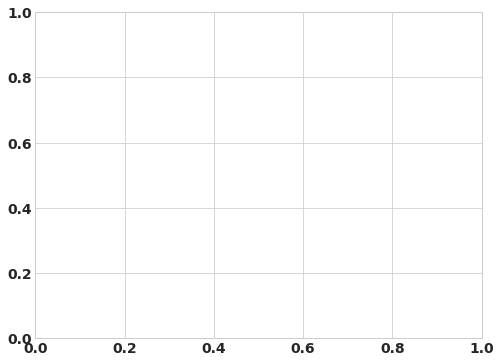

In [24]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], errorbar=None)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)');

### Getting our results

In [26]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'confidence interval 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'confidence interval 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -3.42
p-value: 0.001
confidence interval 95% for control group: [0.092, 0.110]
confidence interval 95% for treatment group: [0.115, 0.134]


# Given that the resulting p-value < 0.05, we reject the Null Hypothesis

## The new webpage did increase the conversion rate. You can congratulate your UX colleague on a job well done!